# Predicting Hospital Length of Stay of General Surgical Patients

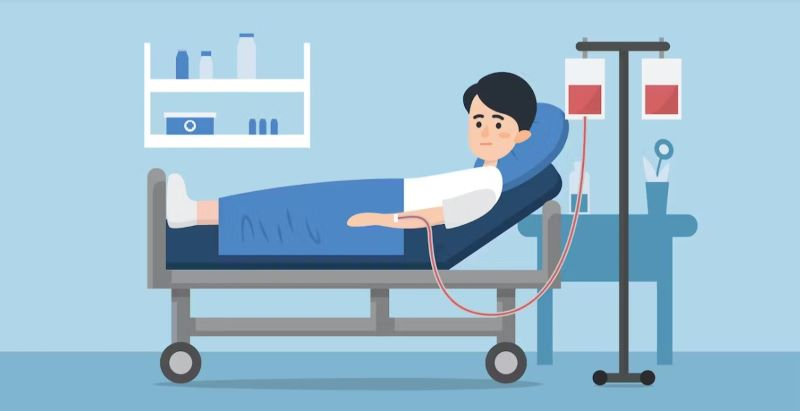

### Part 1

In [1]:
#Import libraries

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

from scipy.stats import chi2_contingency  
from scipy.stats import norm

In [2]:
# Import csv with column description

columndescrip=pd.read_csv("clinical_parameters.csv")
columndescrip.head()

,Parameter;Data Source;Description;Unit
0,caseid;Random;Case ID;
1,subjectid;EMR;Subject ID;
2,casestart;Case file;Recording Start Time;
3,caseend;Case file;Recording End Time;
4,anestart;Case file;Anesthesia start time;


In [3]:
columndescrip[["Parameter", "Data Source", "Description", "Unit"]] = columndescrip['Parameter;Data Source;Description;Unit'].str.split(';', expand=True)
columndescrip.drop(["Parameter;Data Source;Description;Unit"], axis=1, inplace = True)
columndescrip.head(60)

,Parameter,Data Source,Description,Unit
0,caseid,Random,Case ID,
1,subjectid,EMR,Subject ID,
2,casestart,Case file,Recording Start Time,
3,caseend,Case file,Recording End Time,
4,anestart,Case file,Anesthesia start time,
5,aneend,Case file,Anesthesia end time,
6,opstart,Case file,Operation start time,
7,opend,Case file,Operation end time,
8,devices,Case file,Devices used,
9,tracks,Case file,Number of track parameters,


#### Import Clinical Information Dataset

In [4]:
#Importing Clinical data

df1=pd.read_csv("clinical_data.csv")
df1.head()

,case_id,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,icu_days,death_inhosp,age,sex,height,weight,bmi,asa,emop,department,optype,dx,opname,approach,position,ane_type,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr,preop_ph,preop_hco3,preop_be,preop_pao2,preop_paco2,preop_sao2,cormack,airway,tubesize,dltubesize,lmasize,iv1,iv2,aline1,aline2,cline1,cline2,intraop_ebl,intraop_uo,intraop_rbc,intraop_ffp,intraop_crystalloid,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,0,0,77,M,160.2,67.5,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,NaN,Left radial,NaN,NaN,NaN,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0
1,2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,0,0,54,M,167.3,54.8,19.6,2.0,0,General surgery,Stomach,Advanced gastric cancer,Subtotal gastrectomy,Open,Supine,General,0,0,Normal Sinus Rhythm,Normal,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,NaN,NaN,NaN,NaN,50.0,700.0,0,0,800.0,0,150,0.0,0,100,0,20,0,0,0
2,3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,0,0,62,M,169.1,69.7,24.4,1.0,0,General surgery,Biliary/Pancreas,Gallbladder stone,Cholecystectomy,Videoscopic,Reverse Trendelenburg,General,0,0,Normal Sinus Rhythm,Normal,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,200.0,0,0,0.0,0,50,0,0,0,0,0
3,4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,1,0,74,M,160.6,53.0,20.5,2.0,0,General surgery,Stomach,Advanced gastric cancer,Distal gastrectomy,Videoscopic,Reverse Trendelenburg,General,1,0,Normal Sinus Rhythm,Normal,14.4,275.0,103.0,34.5,141.0,4.2,108.0,4.1,23.0,18.0,10.0,0.96,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,NaN,NaN,NaN,Left forearm,NaN,Right radial,NaN,NaN,NaN,NaN,270.0,0,0,2700.0,0,80,0.0,100,100,0,50,0,0,0
4,5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,13,0,66,M,171.0,59.7,20.4,3.0,1,General surgery,Vascular,Aortic aneurysm,Aneurysmal repair,Open,Prone,General,1,0,Left anterior fascicular block,Normal,10.1,67.0,73.0,36.5,146.0,4.4,126.0,2.6,765.0,77.0,50.0,4.43,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,NaN,Right radial,NaN,Right IJV,NaN,2600.0,1490.0,8,8,7100.0,0,0,0.0,0,160,0,10,900,0,2100


#### Import Laboratory Results Dataset

In [5]:
df2 = pd.read_csv("lab_data.csv")

In [6]:
df2.head()

,caseid;dt(test time (seconds based on casestart);name;result
0,1;594470;alb;2.9
1,1;399575;alb;3.2
2,1;12614;alb;3.4
3,1;137855;alb;3.6
4,1;399575;alt;12


In [7]:
#changing column names

df2[["case_id", "lab_test_time", "lab_name", "lab_result"]] = df2['caseid;dt(test time (seconds based on casestart);name;result'].str.split(';', expand=True)
df2.drop(["caseid;dt(test time (seconds based on casestart);name;result"], axis=1, inplace = True)
df2.head()

,case_id,lab_test_time,lab_name,lab_result
0,1,594470,alb,2.9
1,1,399575,alb,3.2
2,1,12614,alb,3.4
3,1,137855,alb,3.6
4,1,399575,alt,12


In [8]:
#Function to remove extra spaces

def whitespace_remover(dataframe):
    # iterating over the columns
    for i in dataframe.columns:
        if dataframe[i].dtype == 'object':
            # applying strip function to each column
            dataframe[i] = dataframe[i].str.replace(" ", "")
        else:
            # if condn. is False then it will do nothing.
            pass

whitespace_remover(df2)   #remove extra spaces from df2

In [9]:
#Changing datatype from object to numeric (including case_id so I am able to merge both tables later using case_id)

df2[['case_id', 'lab_test_time', 'lab_result']] = df2[['case_id', 'lab_test_time', 'lab_result']].apply(pd.to_numeric)

In [10]:
df3=df2.copy()

In [11]:
# Function to get the last laboratory result before discharge for each patient

def get_postop_lab_results(df3, lab_name):
    # Filter the DataFrame for the given lab_name
    lab_rows = df3[df3['lab_name'] == lab_name]

    # Find the index of the maximum lab_test_time for each case_id

    max_time_index = lab_rows.groupby('case_id')['lab_test_time'].idxmax()

    # Extract the lab_result corresponding the maximum lab_test_time which will be the last result for the patient before discharge
    #max_lab_result_df = lab_rows.loc[max_time_index, ['case_id', 'lab_result']].rename(columns={'lab_result': 'f'{lab_name}_end'})
    max_lab_result_df = lab_rows.loc[max_time_index, ['case_id', 'lab_result']].rename(columns={'lab_result': f'postop_{lab_name}'})
                                                                                                
    # Merge the lab result DataFrames back into the original DataFrame based on the 'case_id' column

    df3 = pd.merge(df3, max_lab_result_df, on='case_id', how='left')
    
    return df3

In [12]:
#Getting last lab result measured for each patient of hemoglobin(hb), platelets (plt), glucose and creatinine (cr) which is a indicator of poor kidney function if high.

df3 = get_postop_lab_results(df3, 'hb')
df3 = get_postop_lab_results(df3, 'plt')
df3 = get_postop_lab_results(df3, 'gluc')
df3 = get_postop_lab_results(df3, 'cr')


df3.drop(["lab_test_time", "lab_name", "lab_result"], axis=1, inplace = True)

In [13]:
df3.drop_duplicates(inplace=True)

In [14]:
# Merging Laboratory Results with Clinical Information dataframe

both_df = pd.merge(df1, df3, on='case_id', how='left')

In [ ]:
# Saving it to a csv file.

both_df.to_csv("clinical_and_lab_info.csv")

## Exploratory Data Analysis (EDA)

### 1. Importing data

In [15]:
df = pd.read_csv("clinical_and_lab_info.csv", index_col=0)
df.head(5)

,case_id,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,icu_days,death_inhosp,age,sex,height,weight,bmi,asa,emop,department,optype,dx,opname,approach,position,ane_type,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr,preop_ph,preop_hco3,preop_be,preop_pao2,preop_paco2,preop_sao2,cormack,airway,tubesize,dltubesize,lmasize,iv1,iv2,aline1,aline2,cline1,cline2,intraop_ebl,intraop_uo,intraop_rbc,intraop_ffp,intraop_crystalloid,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca,postop_hb,postop_plt,postop_gluc,postop_cr
0,1,5955,0,11542,-552,10848.0,1668,10368,-236220,627780,0,0,77,M,160.2,67.5,26.3,2.0,0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,1,0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,NaN,Left radial,NaN,NaN,NaN,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0,11.5,242.0,198.0,0.72
1,2,2487,0,15741,-1039,14921.0,1721,14621,-221160,1506840,0,0,54,M,167.3,54.8,19.6,2.0,0,General surgery,Stomach,Advanced gastric cancer,Subtotal gastrectomy,Open,Supine,General,0,0,Normal Sinus Rhythm,Normal,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,NaN,NaN,NaN,NaN,50.0,700.0,0,0,800.0,0,150,0.0,0,100,0,20,0,0,0,11.8,146.0,114.0,0.82
2,3,2861,0,4394,-590,4210.0,1090,3010,-218640,40560,0,0,62,M,169.1,69.7,24.4,1.0,0,General surgery,Biliary/Pancreas,Gallbladder stone,Cholecystectomy,Videoscopic,Reverse Trendelenburg,General,0,0,Normal Sinus Rhythm,Normal,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,200.0,0,0,0.0,0,50,0,0,0,0,0,NaN,NaN,NaN,NaN
3,4,1903,0,20990,-778,20222.0,2522,17822,-201120,576480,1,0,74,M,160.6,53.0,20.5,2.0,0,General surgery,Stomach,Advanced gastric cancer,Distal gastrectomy,Videoscopic,Reverse Trendelenburg,General,1,0,Normal Sinus Rhythm,Normal,14.4,275.0,103.0,34.5,141.0,4.2,108.0,4.1,23.0,18.0,10.0,0.96,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,NaN,NaN,NaN,Left forearm,NaN,Right radial,NaN,NaN,NaN,NaN,270.0,0,0,2700.0,0,80,0.0,100,100,0,50,0,0,0,10.8,360.0,72.0,0.76
4,5,4416,0,21531,-1009,22391.0,2591,20291,-67560,3734040,13,0,66,M,171.0,59.7,20.4,3.0,1,General surgery,Vascular,Aortic aneurysm,Aneurysmal repair,Open,Prone,General,1,0,Left anterior fascicular block,Normal,10.1,67.0,73.0,36.5,146.0,4.4,126.0,2.6,765.0,77.0,50.0,4.43,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,NaN,Right radial,NaN,Right IJV,NaN,2600.0,1490.0,8,8,7100.0,0,0,0.0,0,160,0,10,900,0,2100,9.8,240.0,99.0,3.77


In [16]:
# checking number of columns and number of rows

df.shape

(6388, 78)

### Since I am just going to focus on Predicing Hospital Length of Stay in General Surgical Patients, I am going to select only "General Surgery" patients from the full dataset:

In [17]:
df.department.value_counts()

General surgery     4930
Thoracic surgery    1111
Gynecology           230
Urology              117
Name: department, dtype: int64

In [18]:
df1=df[df["department"]=="General surgery"]

#### General Glimpse

In [19]:
print("The dataframe has {} rows and {} columns".format(df1.shape[0],df1.shape[1]))
print("The data types of each column of the dataframe are:")
print(df1.info())


The dataframe has 4930 rows and 78 columns
The data types of each column of the dataframe are:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4930 entries, 0 to 6386
Data columns (total 78 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   case_id              4930 non-null   int64  
 1   subjectid            4930 non-null   int64  
 2   casestart            4930 non-null   int64  
 3   caseend              4930 non-null   int64  
 4   anestart             4930 non-null   int64  
 5   aneend               4930 non-null   float64
 6   opstart              4930 non-null   int64  
 7   opend                4930 non-null   int64  
 8   adm                  4930 non-null   int64  
 9   dis                  4930 non-null   int64  
 10  icu_days             4930 non-null   int64  
 11  death_inhosp         4930 non-null   int64  
 12  age                  4930 non-null   object 
 13  sex                  4930 non-null   object

We can see there are columns with almost 100% of Null Values!!

In [20]:
# Check Duplicated rows
print("Duplicates:", df1.duplicated().sum()) #check if there are any duplicated rows.

# Check if there are any empty strings
print("Empty Spaces:", df1.eq(' ').sum().sort_values(ascending=False))


Duplicates: 0
Empty Spaces: case_id      0
airway       0
aline2       0
aline1       0
iv2          0
            ..
ane_type     0
position     0
approach     0
opname       0
postop_cr    0
Length: 78, dtype: int64


### 2. Data Cleaning

Before we start cleaning and exploring data I am going to add another column first with Length of Stay (LOS) in days, which I will use to create a categorical column which will be my **target variable.**

#### Target Variable: Categorize the target for the classification problem



1.Add a new column with Hospital Length of Stay (LOS) in days after surgery

In [21]:
# Using column "dis": discharge time from casestart (0) in seconds.

df1["LOS_days"]=df1["dis"]/86400   # To get new column in days
df1["LOS_days"]=df1["LOS_days"].round(0)
df1.LOS_days.describe()

count     4930.000000
mean        -1.377890
std        607.702833
min     -42655.000000
25%          2.000000
50%          5.000000
75%          8.000000
max        197.000000
Name: LOS_days, dtype: float64

In [22]:
neg=df1[df1['LOS_days'] < 0]     # select only negative values
neg['LOS_days'].value_counts()

-1.0        11
-42655.0     1
Name: LOS_days, dtype: int64

There are 12 patients with negative numbers for LOS. 
It can be an entry error or related with icu admission or death? Im going to select only positive values.

In [23]:
# Selecting only positive values por our target variable.
    
df1 = df1[df1['LOS_days'] >= 0] 

2.Add a new column classifying LOS_days into 3 classes: **Short, Average or Prolonged**

This is going to be our multiclass **Target Variable**!

In [24]:
# Function to create column with categories from LOS_days column

def categ_LOS(optype, los):
    means = df1.groupby('optype')['LOS_days'].mean().round()  #using the mean for each operation type.
    if los < means[optype]-2:
        return 'short'
    elif (los >= means[optype] -1) & (los<means[optype] +1):
        return 'medium'
    else:
        return 'prolonged'

df1['LOS'] = df1.apply(lambda x: categ_LOS(x['optype'], x['LOS_days']), axis=1)

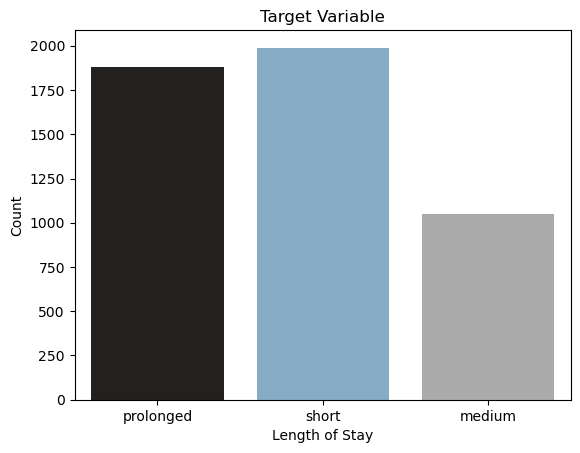

In [25]:
# visualize our Target classes

colors = ["#231F20", "#7CAED1", "#ABABAB"]
sns.countplot(data=df1, x="LOS", palette=colors)
plt.xlabel("Length of Stay")
plt.ylabel("Count")
plt.title("Target Variable")
plt.show()

In [26]:
# Also, let's transform column "caseend" from seconds to minutes

df1["caseend"] =  df1["caseend"]/60
df1["caseend"] = df1["caseend"].round()

### Let's continue to explore our dataset...

Since we have 80 columns and some of them have almost 100% of missing data, I am going to check those first and then see if I can drop any irrelevant columns based on domain knowledge.

#### Handling Missing Values

In [29]:
nulls_percent = pd.DataFrame(df1.isna().sum()*100/len(df1)).reset_index() 
nulls_percent.columns = ['column_name', 'nulls_percentage']
nulls_percent['nulls_percentage'] = nulls_percent['nulls_percentage'].round(1)
nulls_percent.sort_values('nulls_percentage', ascending = False).head(10)

,column_name,nulls_percentage
51,dltubesize,99.6
58,cline2,98.9
52,lmasize,98.3
56,aline2,98.1
44,preop_be,92.1
43,preop_hco3,92.0
47,preop_sao2,92.0
42,preop_ph,91.9
46,preop_paco2,91.9
45,preop_pao2,91.9


In [30]:
# Store columns above threshold (more than 85% of missing values) in a list called "drop_column_list".

columns_above_threshold = nulls_percent[nulls_percent['nulls_percentage']>85]
drop_columns_list = list(columns_above_threshold['column_name'])

In [31]:
# Adding more columns to the drop_column_list which are not going to be used anymore or are irrelevant 

drop_columns_list.extend(['case_id', 'subjectid', 'casestart', 'anestart', 'aneend', 'opstart', 'opend', 'adm', 'dis', 'death_inhosp', 'department', 'dx', 'opname', 'position', 'preop_pt',  'preop_aptt', 'preop_na', 'preop_k', 'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'airway', 'tubesize', 'iv2'])
df2 = df1.drop(columns=drop_columns_list) # Dropping those columns

print ("Ok, we are down to 45 columns!")

Ok, we are down to 45 columns!


#### "iv1", "aline1" and "cline1" Columns

iv1: Location of peripheral IV line during surgery.

aline1: Location of the arterial line during surgery.

cline1: Location of central line during surgery. 

I assume that Null values means patient did not have line during surgery, therefore no data was inserted.


In [32]:
#Replace null values with "unknown" 

columns_lines_nulls = ['iv1', 'aline1', 'cline1']
df2[columns_lines_nulls] = df2[columns_lines_nulls].fillna('unknown')

#### "intraop_uo" Column

Intraoperative urine output in ml. **2210 Null values**. 

This column can also be a good predictor for LOS, therefore I do not want to drop this column.

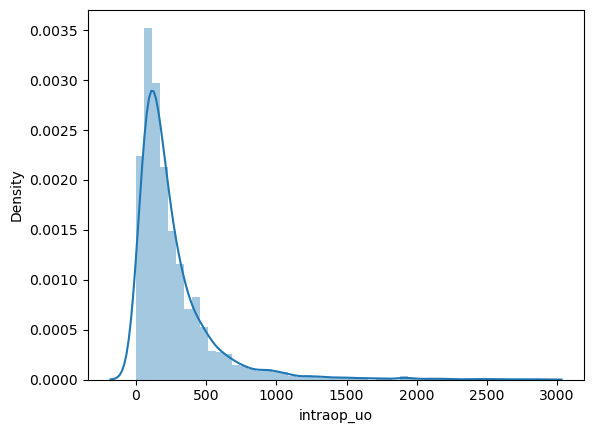

In [33]:
#Let's first check urine output distribution

sns.distplot(df2['intraop_uo'])
plt.show()

I am going to use median imputation because data is slightly skewed to the right. Mean imputation works better if the data is normally-distributed, which is not the case.

In [34]:
impute_median = SimpleImputer(strategy = 'median')
impute_median.fit(df2[['intraop_uo']])  #fit the imputer to the column 'cormack'
df2['intraop_uo'] = impute_median.transform(df2[['intraop_uo']])

#### "intraop_ebl" Column

Estimated blood loss in ml. **1832 Null values**. 

If no value was inserted during surgery I am assuming patient did not loose a considerable amount of blood, therefore I am going to replace Null values with 0 ml.


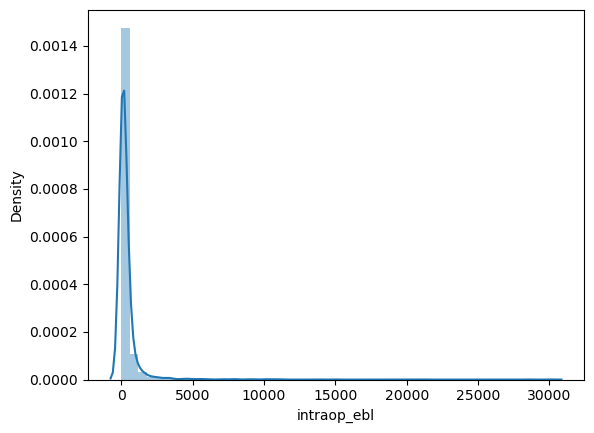

In [35]:
sns.distplot(df2['intraop_ebl'])
plt.show()

In [36]:
df2['intraop_ebl']=df2['intraop_ebl'].fillna(0)

#### "cormack" and "asa" Columns

Cormack's grade is a scale that describes the best view of the glottis during laryngoscopy, which can predict difficult intubation during anaesthesia + complications associated and lead to a prolonged LOS. **685 Null Values**

ASA is a grading tool to assess the fitness of patients before surgery, this can be important to predict LOS. **87 Null Values**.

In [37]:
df2.cormack.value_counts()

I       3953
II       176
IIIa      73
IIIb      21
IV        10
Name: cormack, dtype: int64

In [38]:
# Replace Null values with "mode" (most frequest value) since both columns are categorical with ordinal data.

impute_mode = SimpleImputer(strategy = 'most_frequent')
impute_mode.fit(df2[['cormack','asa']])  #fit the imputer

SimpleImputer(strategy='most_frequent')

In [39]:
# Transform and replace the missing values with the mode
df2[['cormack', 'asa']] = impute_mode.transform(df2[['cormack', 'asa']])

In [40]:
#convert from int to object (discrete numerical)
df2['asa']=df2['asa'].astype(object)


#### "intraop_crystalloid" Column

Intraoperative crystalloid (a type of Intravenous solution). **319 Null values**

<AxesSubplot:xlabel='intraop_crystalloid', ylabel='Density'>

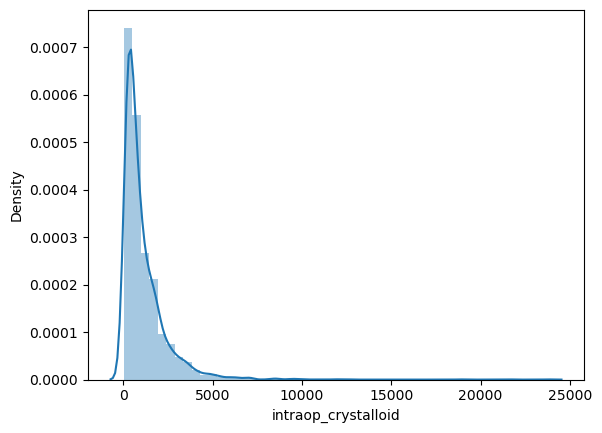

In [41]:
sns.distplot(df2['intraop_crystalloid'])

In [42]:
# Median imputation because column do not follow a normal distribution.
impute_median = SimpleImputer(strategy = 'median')
impute_median.fit(df2[['intraop_crystalloid']])  #fit the imputer to the column 'cormack'
df2['intraop_crystalloid'] = impute_median.transform(df2[['intraop_crystalloid']])

#### Laboratory Results Columns (pre and post surgery)

In [43]:
labs_pre_post=df2[['preop_hb', 'postop_hb', 'preop_plt', 'postop_plt', 'preop_cr', 'postop_cr', 'preop_gluc', 'postop_gluc']].copy()
labs_pre_post.isna().sum()

preop_hb        185
postop_hb       995
preop_plt       179
postop_plt      997
preop_cr        201
postop_cr      1072
preop_gluc      203
postop_gluc    1237
dtype: int64

Postop laboratory results: There are almost 1000 values missing in some columns... I do not want to remove those rows because otherwise I will loose almost 1000 patients (almost 20%) from my dataset!

Since I cannot guess what the laboratory results are for these patients I am going to drop these columns.
Regarding pre op results, there are a maximum of 182 values missing, I will drop these rows.

In [44]:
df2.drop(columns=['postop_hb', 'postop_plt', 'postop_cr', 'postop_gluc'], inplace=True) #dropping columns

In [45]:
df2.dropna(subset=['preop_hb', 'preop_plt', 'preop_cr', 'preop_gluc'], inplace=True) # deleting rows with null values

#### "Age" Column (Binning)

In [46]:
df2['age'] = df2['age'].str.replace('>', '')
df2['age'] = pd.to_numeric(df2['age'], errors='coerce')

In [47]:
# Transform age into groups

def group_year(val):
    if val in [0, 18]:
        return "children"
    elif val in [19, 35]:
        return "young adults"
    elif val in [36, 55]:
        return "middle aged adults"
    elif val in [56, 75]:
        return "older adults"
    else: 
        return "elderly age"

In [48]:
df2['age'] = df2['age'].apply(group_year)

#### "intraop_rbc"

Intraop red blood cells - If patient was transfused with blood. 
No missing values but most of the values are 0, therefore most of the patients did not have blood, therefore I am going to create buckets for the rest of the values.

In [50]:
def blood_(val):
    if val == 0:
        return "0"
    elif val in [1, 4]:
        return "1-4"
    elif val in [5, 10]:
        return "5-10"
    elif val in [11, 15]:
        return "11-15"
    else: 
        return "above 15"

In [51]:
df2['intraop_rbc'] = df2['intraop_rbc'].apply(blood_)

In [52]:
df2.intraop_rbc.value_counts()

0           4397
above 15     142
1-4          117
5-10          10
11-15          4
Name: intraop_rbc, dtype: int64

In [53]:
# Rename columns names to make it easier to understand

df2 = df2.rename(columns = {'caseend':'surgery_time_min',
    'emop':'emergency_op','optype':'op_type', 'approach':'surgical_approach','preop_pft':'preop_pulm_function',
    'iv1':'iv_line', 'aline1':'arterial_line',
    'cline1':'central_line', 'intraop_ebl':'intraop_blood_loss',
    'intraop_uo':'intraop_urine','intraop_rbc':'rbc_transfusion','intraop_ffp':'ffplasma_transfusion','intraop_ppf':'propofol',
    'intraop_mdz':'midazolam', 'intraop_ftn':'fentanyl','intraop_rocu':'rocuronium','intraop_vecu':'vecuronium',
    'intraop_eph':'ephedrine','intraop_phe':'phenylephrine','intraop_epi':'Epinephrine',
    'intraop_ca':'calcium chloride'
})

In [54]:
# Transform columns from integer type to object type since they are categorical (discrete numerical) for visualizations
df2[['emergency_op','preop_htn','preop_dm']] = df2[['emergency_op','preop_htn','preop_dm']].astype(object)

In [55]:
# Transform columns from integer type to object type since they are categorical (discrete numerical) for visualizations
df2[['emergency_op','preop_htn','preop_dm']] = df2[['emergency_op','preop_htn','preop_dm']].astype(object)

### 3. Categorical Features Exploration

In [56]:
#Extract categorical variables

categorical = df2.select_dtypes(include = np.object)

#### Relationship between independent categorical features and Target "LOS".

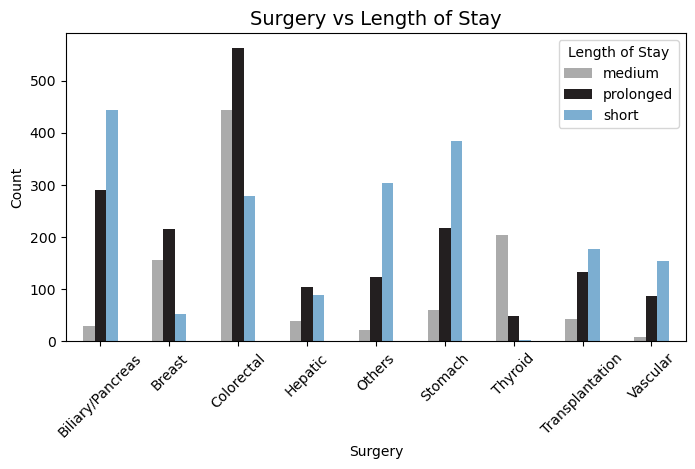

In [57]:
# How different surgeries affects Length of Stay

crosstab = pd.crosstab(categorical.op_type, categorical.LOS)
barplot = crosstab.plot.bar(rot=45, figsize=(8, 4), color=['#ABABAB', '#231F20', '#7CAED1'])

barplot.set_xlabel("Surgery")
barplot.set_ylabel("Count")
barplot.set_title("Surgery vs Length of Stay", fontsize=14)
barplot.legend(title='Length of Stay', loc='upper right')

We can see that Breast, Colorectal and Hepatic surgeries are associated with more prolonged Hospital Length of Stay.
Probably it is related with cancer where patients are more frail and susceptible to infections and increased risk of postoperative complications leading to an increased stay.

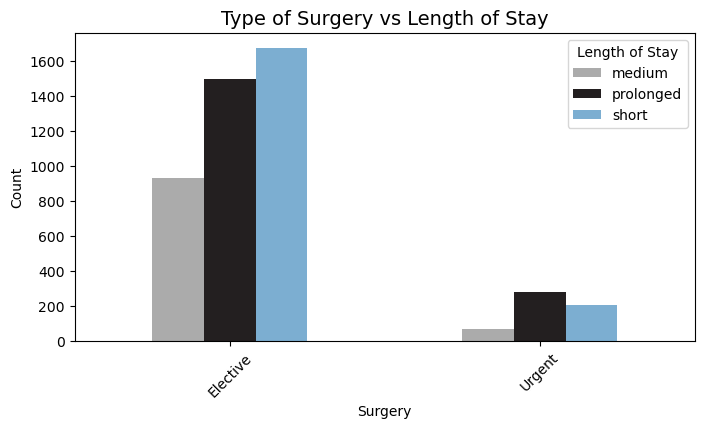

In [58]:
# planned vs urgent surgery affects Length of Stay

categorical['emergency_op'] = categorical['emergency_op'].replace({1: 'Urgent', 0: 'Elective'})
crosstab = pd.crosstab(categorical.emergency_op, categorical.LOS)
barplot = crosstab.plot.bar(rot=45, figsize=(8, 4), color=['#ABABAB', '#231F20', '#7CAED1'])

barplot.set_xlabel("Surgery")
barplot.set_ylabel("Count")
barplot.set_title("Type of Surgery vs Length of Stay", fontsize=14)
barplot.legend(title='Length of Stay', loc='upper right')

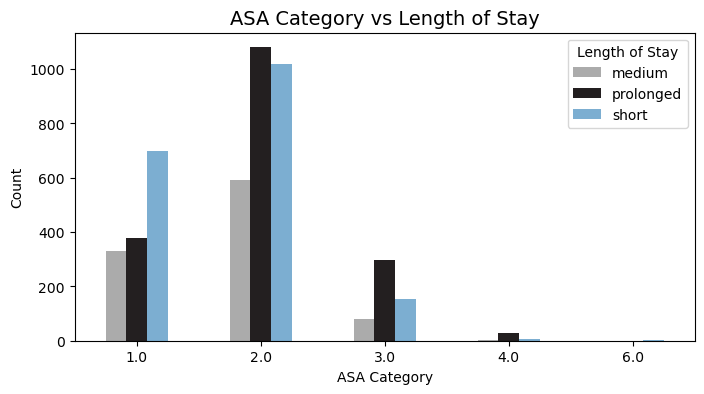

In [59]:
# How ASA Score affects LOS

crosstab = pd.crosstab(categorical.asa, df2.LOS)
barplot = crosstab.plot.bar(rot=0,figsize=(8, 4), color=['#ABABAB', '#231F20', '#7CAED1'])

barplot.set_xlabel("ASA Category")
barplot.set_ylabel("Count")
barplot.set_title("ASA Category vs Length of Stay", fontsize=14)
barplot.legend(title='Length of Stay', loc='upper right')


We can see that ASA scores of 2, 3 and 4 are associated with a prolonged length of stay.

ASA score is a pre-op assessment of a patient's overall health, therefore as expected, patients with previous medical history and chronic conditions are associated with significantly longer length of stay.

#### Let's check if patients with pre-op Diabetes and pre-op Hypertension confirms that:


[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

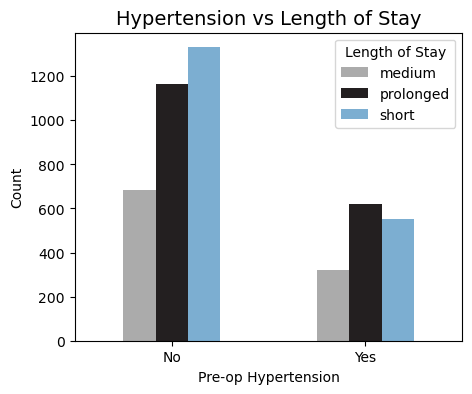

In [60]:
crosstab = pd.crosstab(categorical.preop_htn, df2.LOS)
barplot = crosstab.plot.bar(rot=0,figsize=(5, 4), color=['#ABABAB', '#231F20', '#7CAED1'])

barplot.set_xlabel("Pre-op Hypertension")
barplot.set_ylabel("Count")
barplot.set_title("Hypertension vs Length of Stay", fontsize=14)
barplot.legend(title='Length of Stay', loc='upper right')

x_labels = ['No', 'Yes'] 
barplot.set_xticklabels(x_labels)

In [ ]:
crosstab = pd.crosstab(categorical.preop_dm, df2.LOS)
barplot = crosstab.plot.bar(rot=0,figsize=(5, 4), color=['#ABABAB', '#231F20', '#7CAED1'])

barplot.set_xlabel("Pre-op Diabetes")
barplot.set_ylabel("Count")
barplot.set_title("Diabetes vs Length of Stay", fontsize=14)
barplot.legend(title='Length of Stay', loc='upper right')

x_labels = ['No', 'Yes'] 
barplot.set_xticklabels(x_labels)

We can clearly see on both bar plots that patients with **Hypertension and Diabetes** have prolonged LOS compared to patients without these conditions. Evaluation and optimization of glycemic levels / hypertension on patients before surgery is crucial to reduce post op complications and the amount of time they need to be hospitalized.  

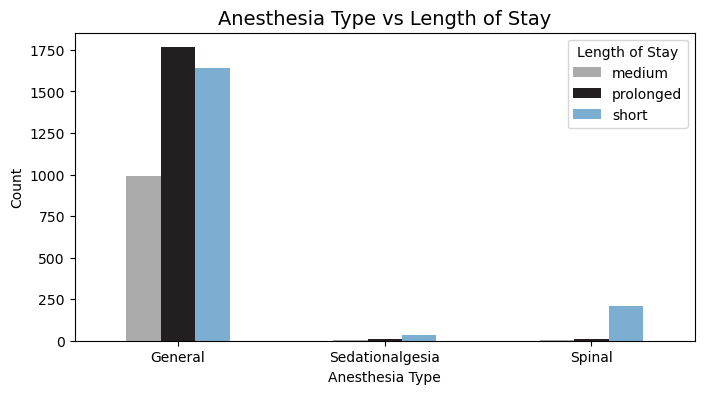

In [61]:
# Now let's see if the type of anesthesia a patient receives have any influence in the LOS

crosstab = pd.crosstab(categorical.ane_type, df2.LOS)
barplot = crosstab.plot.bar(rot=0,figsize=(8, 4), color=['#ABABAB', '#231F20', '#7CAED1'])
barplot.set_xlabel("Anesthesia Type")
barplot.set_ylabel("Count")
barplot.set_title("Anesthesia Type vs Length of Stay", fontsize=14)
barplot.legend(title='Length of Stay', loc='upper right')


We can see here that General Anesthesia is associated with prolonged LOS, as expected, because patients take longer to recover. However, some procedures can be done under Spinal or just under Sedation/Analgesia (sedoanalgesia) instead of General Anesthesia which can definitely minimize time to discharge after surgery, assuming there are no complications.

#### Let's compare the surgery type with anesthesia type:

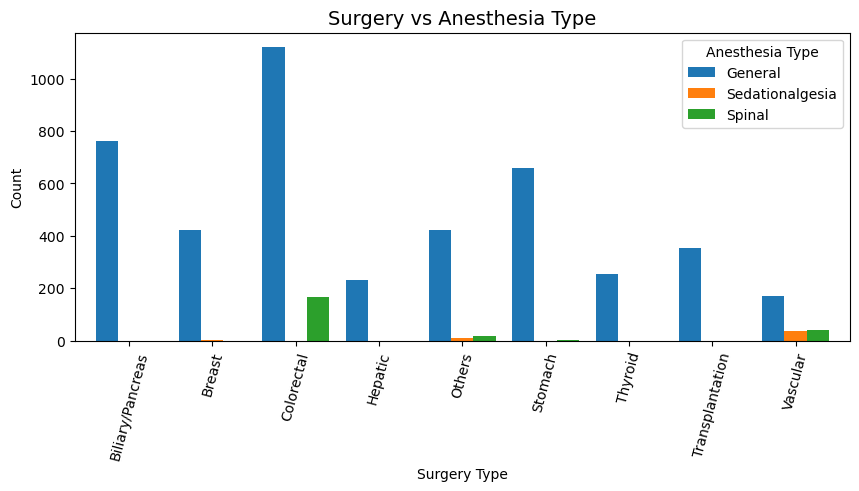

In [62]:
crosstab = pd.crosstab(df2.op_type, df.ane_type)
barplot = crosstab.plot.bar(rot=75,figsize=(10, 4), width=0.8)
barplot.set_xlabel("Surgery Type")
barplot.set_ylabel("Count")
barplot.set_title("Surgery vs Anesthesia Type", fontsize=14)
barplot.legend(title='Anesthesia Type', loc='upper right')


Well, we can see here General Anesthesia (GA) was largely used in almost all general surgical procedures in this dataset.
Spinal anesthesia could be considered especially in some Vacular and small Colorectal procedures as an effective alternative to GA which can lead to lower incidence of complications and consequent less prolonged LOS in Hospital.

#### Surgery Time vs LOS

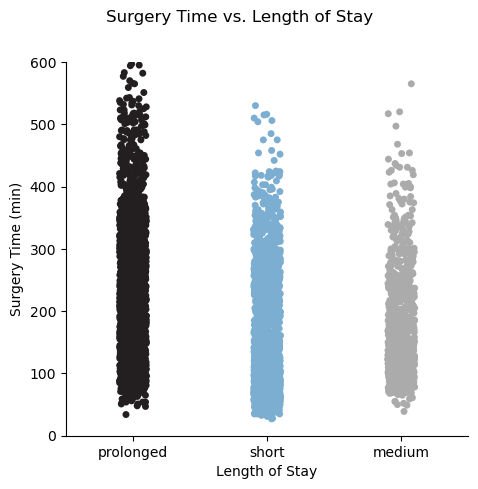

In [63]:
colors = ["#231F20", "#7CAED1", "#ABABAB"]
plot=sns.catplot(data=df2, x="LOS", y="surgery_time_min", palette=colors)
plt.ylim(0, 600)  #range for the x-axis

plot.set_axis_labels("Length of Stay", "Surgery Time (min)")
plot.fig.suptitle("Surgery Time vs. Length of Stay")
plot.tight_layout(pad=1.5) # to adjust the edges

plt.show()

Here we can see that prolonged surgical time is associated with prolonged admission after surgery.

### 3.1 Categorical Features Relationship using Chi-Square Test

When I explored the relationship between categorical variables and target "LOS" with barplots, I checked some high variation in the distribution of some features across different target classes, which can mean those features might have some influence in the target "LOS".

Let's use Chi-squared test to find out if there is any association between my categorical features and the target variable "LOS"!

**H0** (Null Hypothesis) - assumes that there is no association between the two variables, meaning they are not related.

**Ha** (Alternate Hypothesis) - assumes that there is an association between the two variables.

Chosen significance level: 0.05

(https://www.medcalc.org/manual/chi-square-table.php)

In [64]:
#Target "LOS" and "Sex"

df_crosstab = pd.crosstab(categorical['LOS'], categorical['sex'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  26.53
The p-value is:  1.7348554818569598e-06
The number of degrees of freedom is:  2


- Chi2 value > 5.991 -> Reject Null Hypothesis: Relationship between columns are statistically significant (columns are dependent) -> keep column "Sex"

In [65]:
#Target "LOS" and "op_type"

df_crosstab2 = pd.crosstab(categorical['LOS'], categorical['op_type'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab2, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  1419.86
The p-value is:  8.72825799630208e-293
The number of degrees of freedom is:  16


- Chi2 value > 26.296 -> Keep "op_type"

In [66]:
#Target "LOS" and "surgical_approach"

df_crosstab3 = pd.crosstab(categorical['LOS'], categorical['surgical_approach'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab3, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  379.21
The p-value is:  8.6049396439827e-81
The number of degrees of freedom is:  4


- Chi2 value > 9.488 -> Keep "surgical_approach"

In [67]:
#Target "LOS" and "emergency_op"

df_crosstab1 = pd.crosstab(categorical['LOS'], categorical['emergency_op'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab1, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  51.01
The p-value is:  8.38216281178847e-12
The number of degrees of freedom is:  2


- Chi2 value > 5.991 -> Keep  "emergency_op".


In [68]:
#Target "LOS" and "ane_type"

df_crosstab4 = pd.crosstab(categorical['LOS'], categorical['ane_type'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab4, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  302.83
The p-value is:  2.6511312721084163e-64
The number of degrees of freedom is:  4


- Chi2 value > 9.488 -> Keep "ane_type"

In [69]:
#Target "LOS" and "preop_htn"

df_crosstab5 = pd.crosstab(categorical['LOS'], categorical['preop_htn'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab5, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  12.57
The p-value is:  0.00186729377467093
The number of degrees of freedom is:  2


- Chi2 value > 5.991 -> Keep "preop_htn"

In [70]:
#Target "LOS" and "preop_dm"

df_crosstab6 = pd.crosstab(categorical['LOS'], categorical['preop_dm'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab6, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)



The Chi2 value is:  26.96
The p-value is:  1.4016927456592943e-06
The number of degrees of freedom is:  2


- Chi2 value > 5.991 -> Keep "preop_dm"


In [71]:
#Target "LOS" and "preop_ecg"

df_crosstab7 = pd.crosstab(categorical['LOS'], categorical['preop_ecg'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab7, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  45.32
The p-value is:  0.3354135220599732
The number of degrees of freedom is:  42


- Chi2 value < 58.124 -> Drop "preop_ecg"

In [72]:
#Target "LOS" and "preop_pulm_function"

df_crosstab8 = pd.crosstab(categorical['LOS'], categorical['preop_pulm_function'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab8, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  20.34
The p-value is:  0.2053916556994503
The number of degrees of freedom is:  16


- Chi2 value < 26.296  -> Drop "preop_pulm_function"

In [73]:
#Target "LOS" and "cormack"

df_crosstab9 = pd.crosstab(categorical['LOS'], categorical['cormack'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab9, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  9.86
The p-value is:  0.27487250766619786
The number of degrees of freedom is:  8


- Chi2 value < 15.507-> Drop "cormack" column

In [74]:
#Target "LOS" and "iv_line"

df_crosstab10 = pd.crosstab(categorical['LOS'], categorical['iv_line'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab10, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  78.21
The p-value is:  3.178699185299189e-08
The number of degrees of freedom is:  22


- Chi2 value > 33.924 -> Keep iv_line

In [75]:
#Target "LOS" and "arterial_line"

df_crosstab11 = pd.crosstab(categorical['LOS'], categorical['arterial_line'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab11, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  281.16
The p-value is:  1.9999809338307954e-50
The number of degrees of freedom is:  16


- Chi2 value > 28.845 - Keep arterial_line

In [76]:
#Target "LOS" and "central_line"

df_crosstab12 = pd.crosstab(categorical['LOS'], categorical['central_line'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab12, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  345.81
The p-value is:  8.942333331685579e-59
The number of degrees of freedom is:  24


- Chi2 value > 36.415 -> Keep central_line

In [77]:
#Target "LOS" and "rbc_transfusion"

df_crosstab13 = pd.crosstab(categorical['LOS'], categorical['rbc_transfusion'])
chi2, p_value, dof, expected_freq = chi2_contingency(df_crosstab13, correction=False)

print("The Chi2 value is: ",round(chi2,2))
print("The p-value is: ",p_value)
print("The number of degrees of freedom is: ",dof)

The Chi2 value is:  131.26
The p-value is:  1.5516190485249558e-24
The number of degrees of freedom is:  8


- Chi2 value > 12.592 -> Keep rbc_transfusion

In [78]:
drop_columns_cat=(['cormack','preop_ecg', 'preop_pulm_function'])
df_cleaned= df2.drop(columns=drop_columns_cat) 

### 4. Numerical Features Exploration

In [79]:
#Extract numerical variables

numerical = df2.select_dtypes(np.number)

In [80]:
numerical.describe()

,surgery_time_min,icu_days,height,weight,bmi,preop_hb,preop_plt,preop_gluc,preop_cr,intraop_blood_loss,intraop_urine,ffplasma_transfusion,intraop_crystalloid,intraop_colloid,propofol,midazolam,fentanyl,rocuronium,vecuronium,ephedrine,phenylephrine,Epinephrine,calcium chloride,LOS_days
count,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000,4670.000000
mean,188.610921,0.478373,161.998278,61.335392,23.261135,12.825503,239.580728,115.093790,1.148597,235.341970,225.704925,0.131049,1076.622912,30.682655,44.249251,0.038223,19.445396,69.022698,0.002998,8.588865,28.752463,10.415632,132.553533,7.275375
std,111.371589,2.683222,10.366356,12.222359,3.679065,2.040169,85.220894,40.926434,1.767387,985.894742,221.778204,1.271110,1256.316726,135.552392,55.654312,0.353645,40.240798,33.761100,0.118856,12.885068,145.105369,548.932838,576.123275,11.060552
min,27.000000,0.000000,42.000000,4.800000,11.500000,3.500000,5.000000,44.000000,0.100000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,0.000000,156.000000,53.000000,20.900000,11.600000,189.000000,94.000000,0.660000,0.000000,150.000000,0.000000,350.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,159.000000,0.000000,162.100000,60.400000,23.100000,13.000000,234.000000,103.000000,0.780000,50.000000,180.000000,0.000000,700.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,5.000000,0.000000,0.000000,0.000000,5.000000
75%,259.000000,0.000000,168.600000,68.687500,25.300000,14.200000,283.000000,121.000000,0.950000,200.000000,200.000000,0.000000,1400.000000,0.000000,100.000000,0.000000,0.000000,90.000000,0.000000,15.000000,0.000000,0.000000,0.000000,8.000000
max,1029.000000,81.000000,188.600000,139.700000,43.200000,20.200000,970.000000,511.000000,25.620000,30100.000000,2850.000000,38.000000,23800.000000,1900.000000,200.000000,6.000000,200.000000,270.000000,5.000000,300.000000,2950.000000,37220.000000,15900.000000,197.000000


Looking at the descriptive statistics of numerical columns, I can see some columns that might have some outliers by comparing "max" value with mean, however this outliers can be valuable for our model, we will check outliers later.

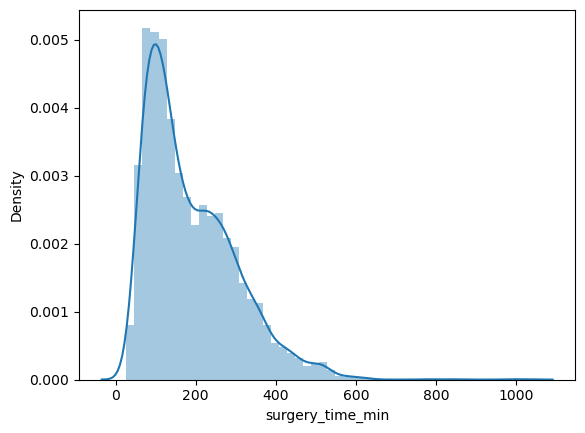

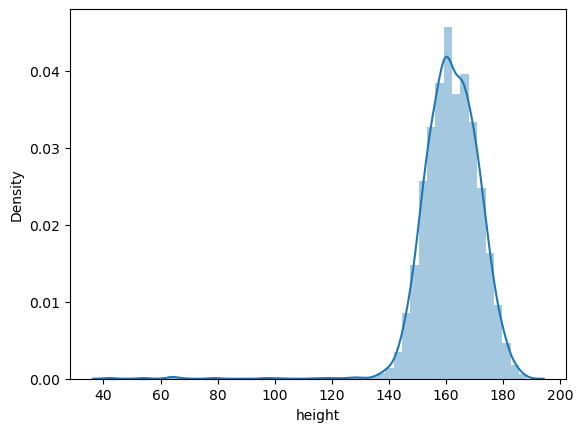

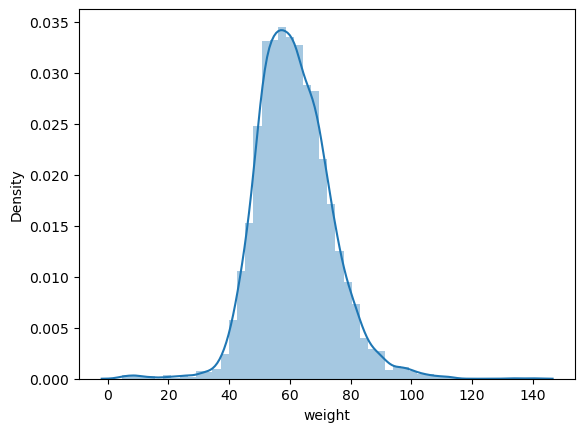

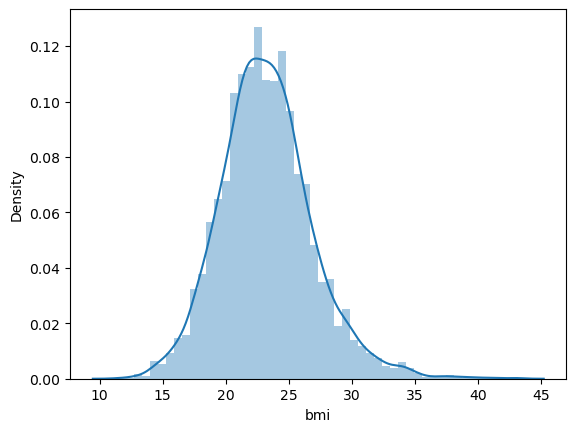

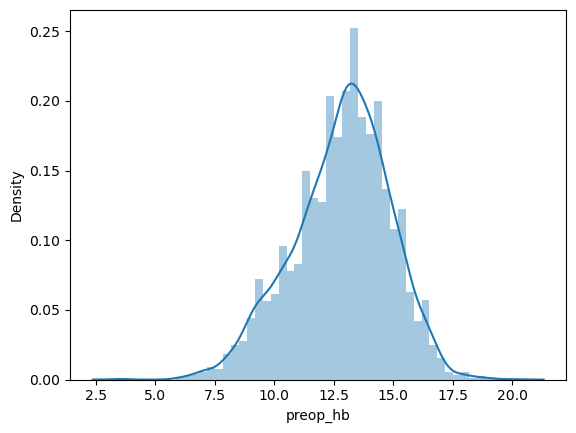

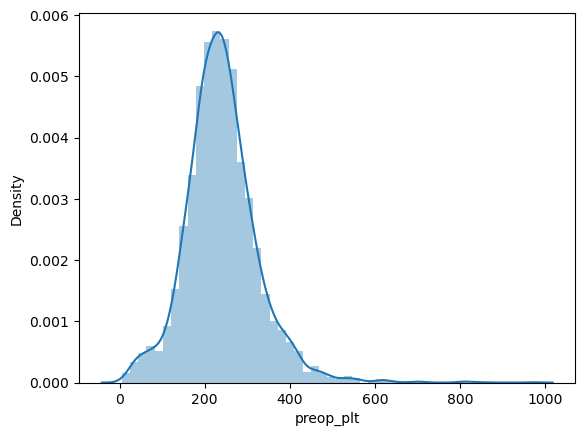

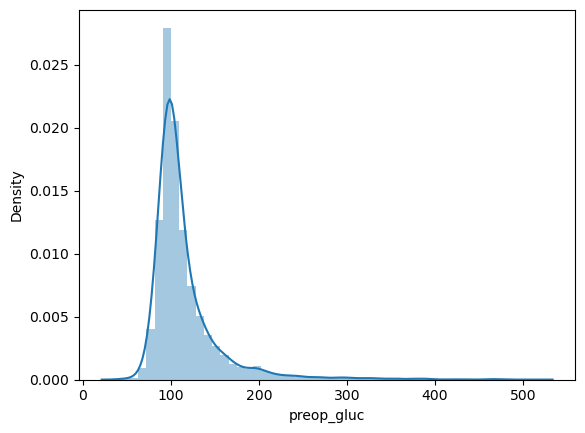

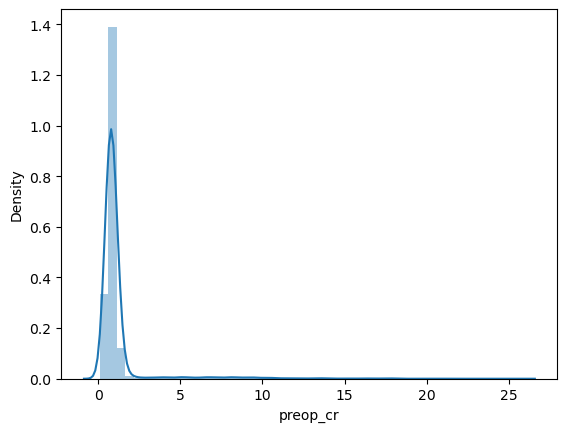

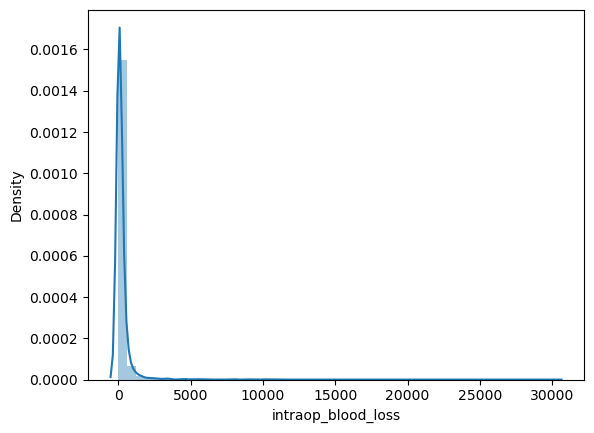

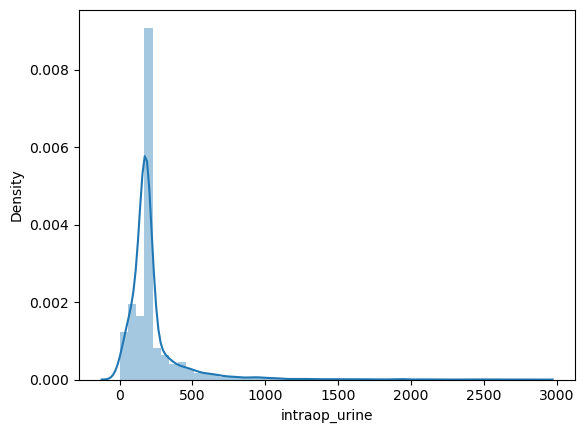

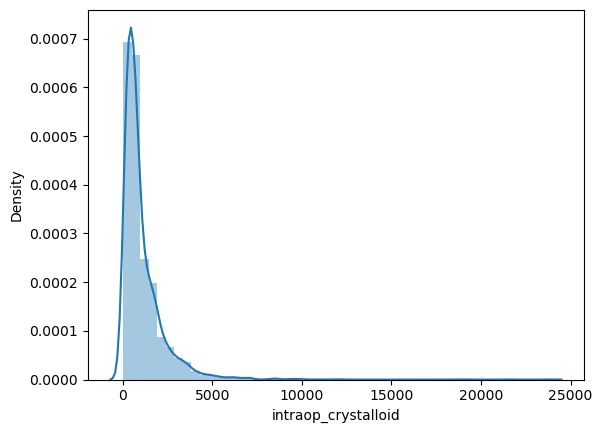

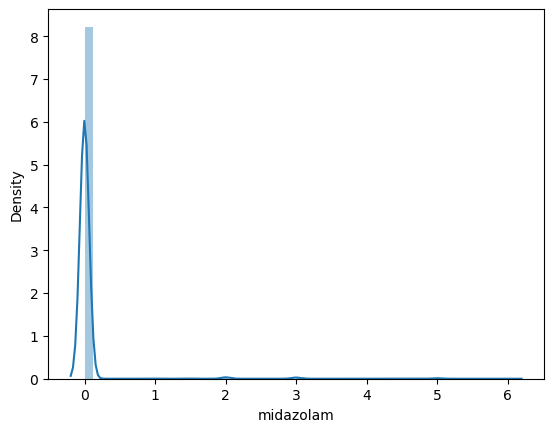

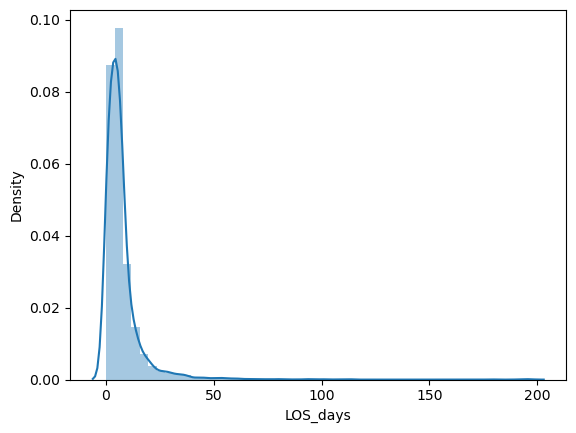

In [81]:
# Visualize distribution of Numerical Continous:

continuous = numerical.select_dtypes(float)

for col in continuous.columns:
    sns.distplot(continuous[col])
    plt.show()

 We can see right skewness on all the columns except on the demographic columns.

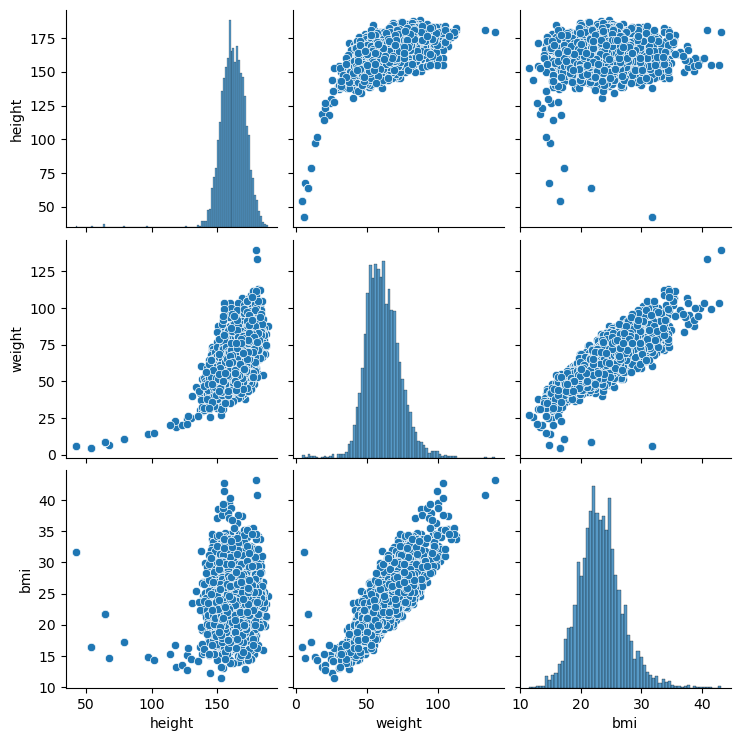

In [82]:
#Let's analyse relationship between numerical variables

#Demographic data

num_demogr=continuous[['height','weight','bmi']]
sns.pairplot(num_demogr)

Clearly and as expected, there is a positive correlation between height, weight and bmi!

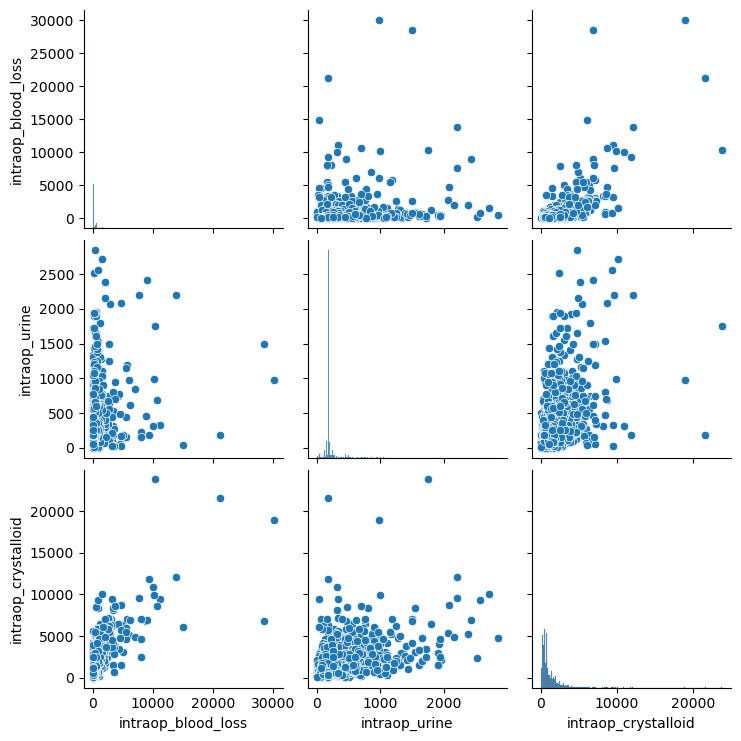

In [83]:
# Explore urine/blood output and fluids/blood administration.

fluids=numerical[['intraop_blood_loss', 'intraop_urine', 'intraop_crystalloid']]
sns.pairplot(fluids)


- Intraop_blood_loss is positive correlated with intraop_crystalloid, as expected (patient loosing blood -> hypotension -> compensate with IV fluids)
- intraop_crystalloid positive correlated with intraop_urine, as expected as well, more fluids -> more urinary production.

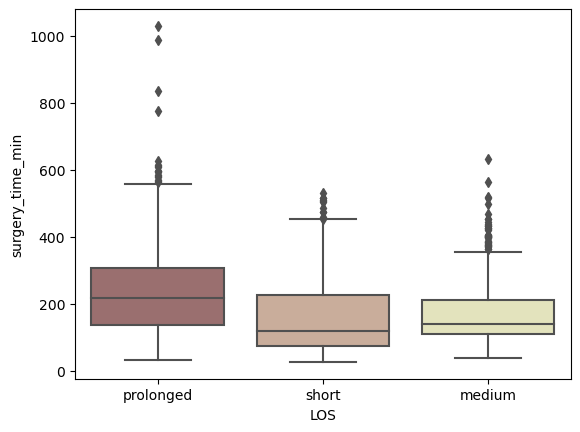

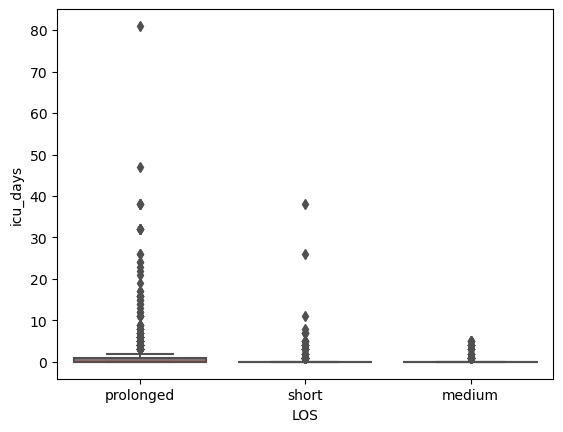

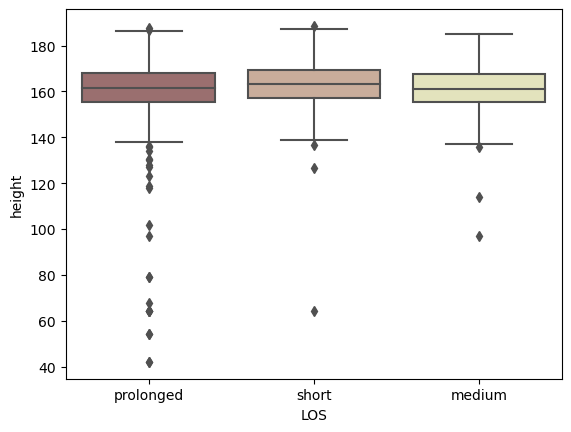

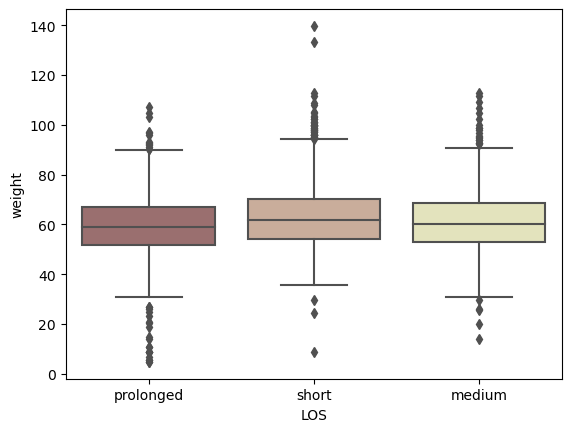

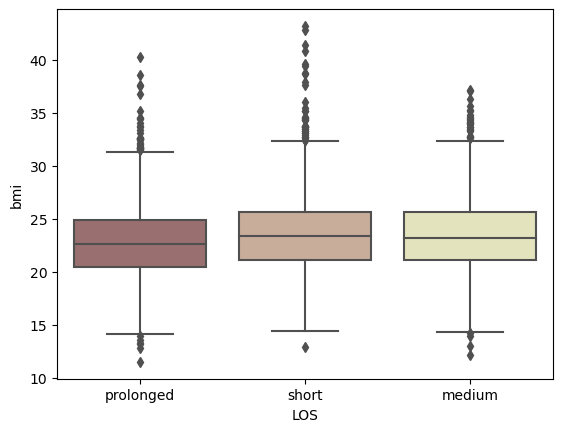

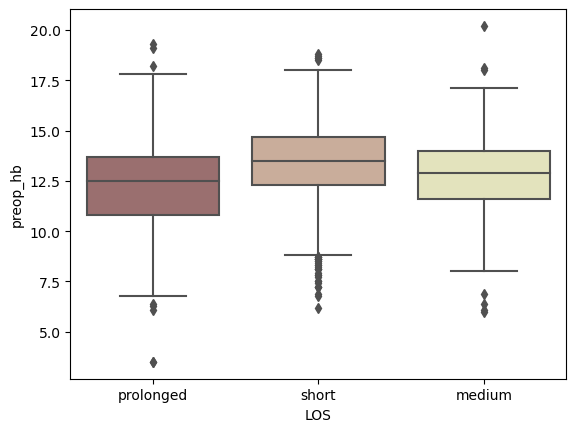

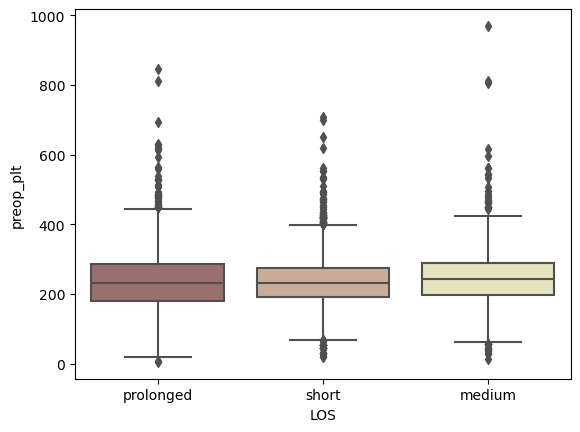

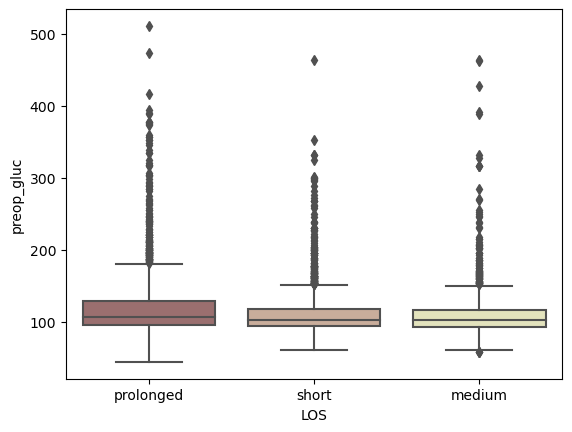

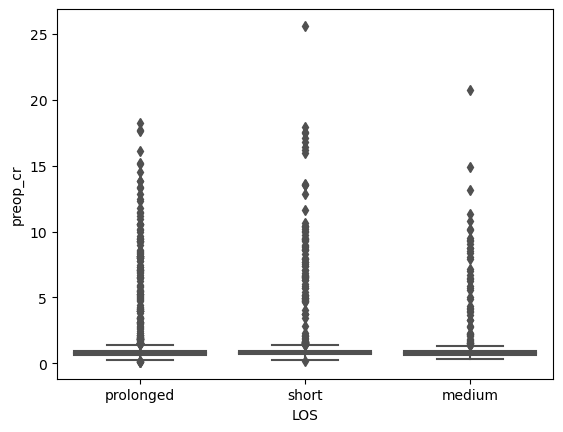

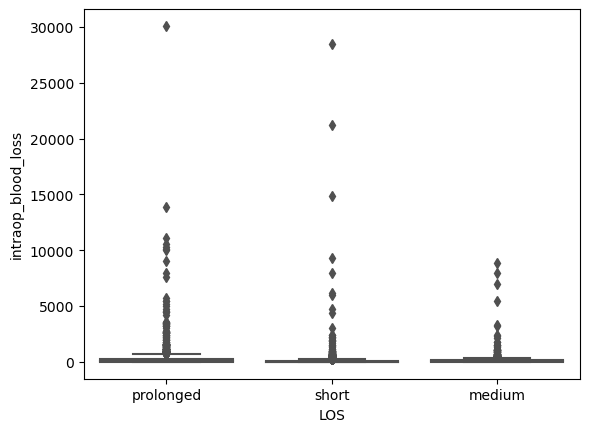

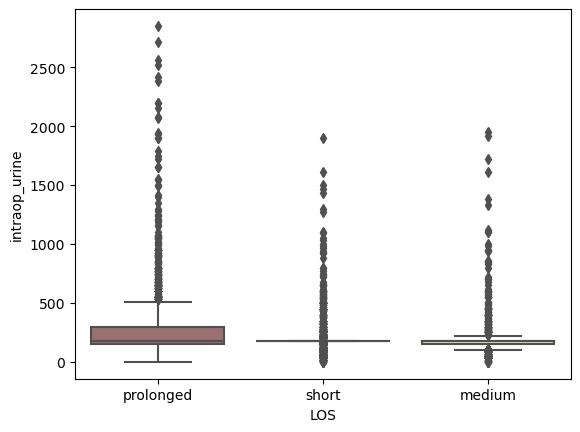

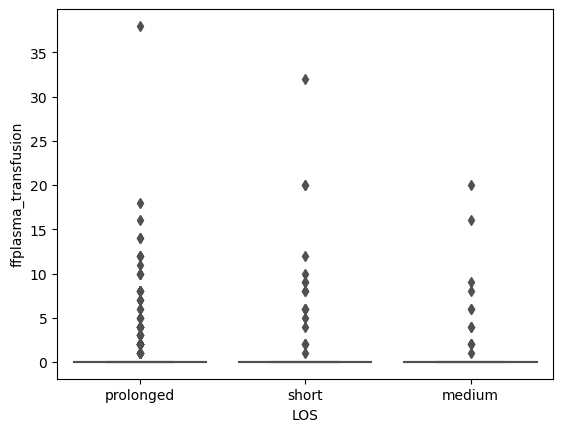

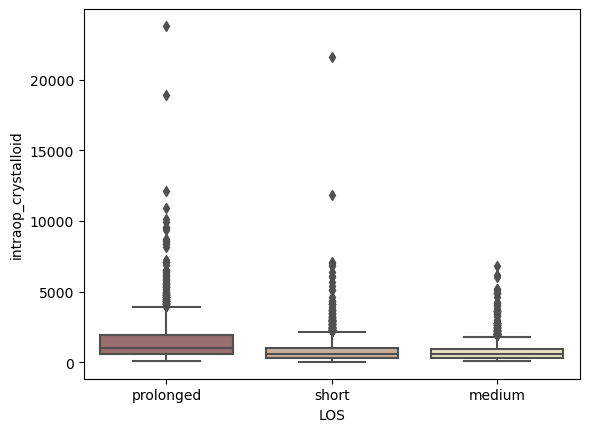

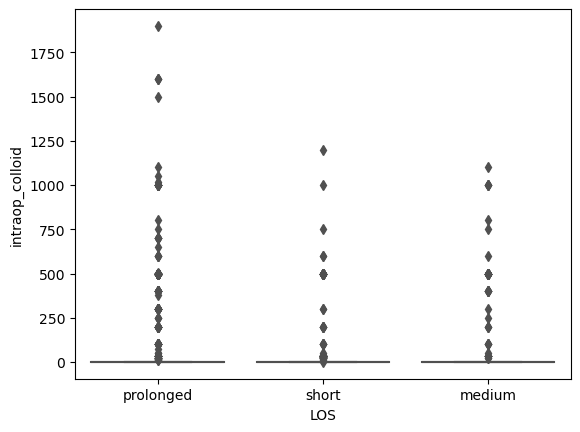

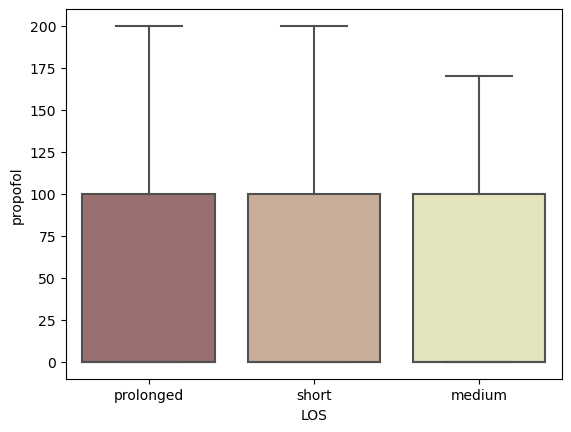

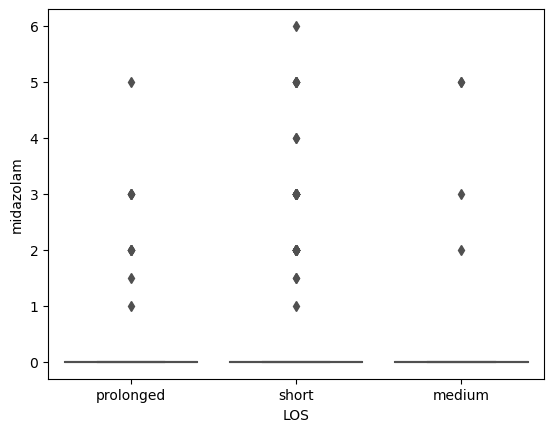

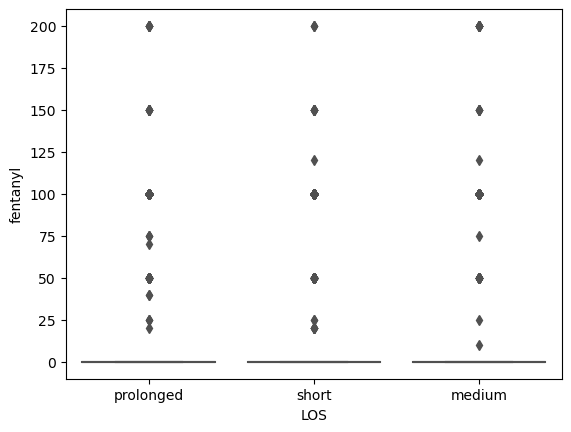

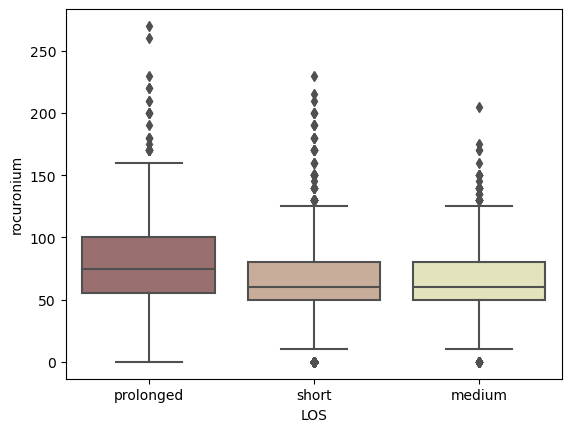

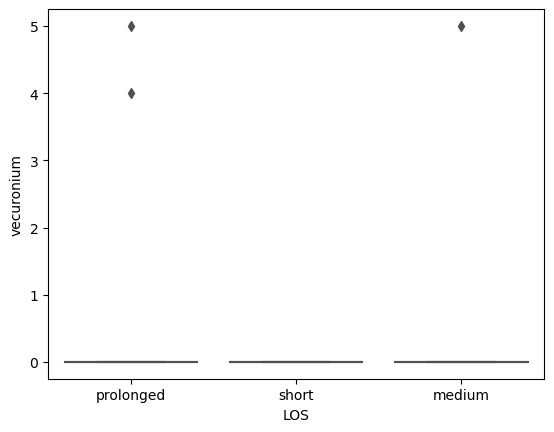

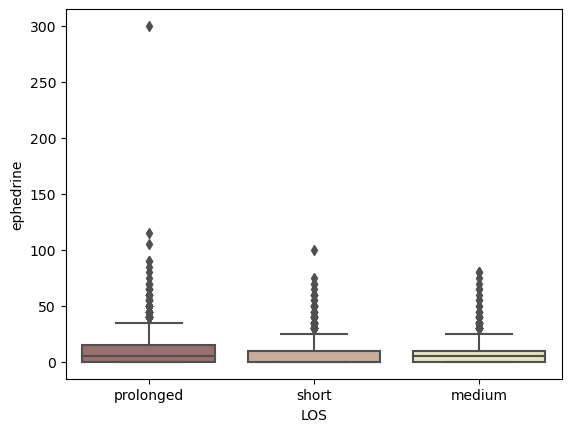

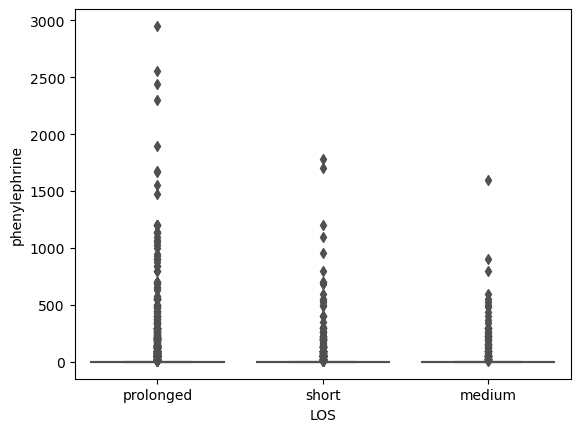

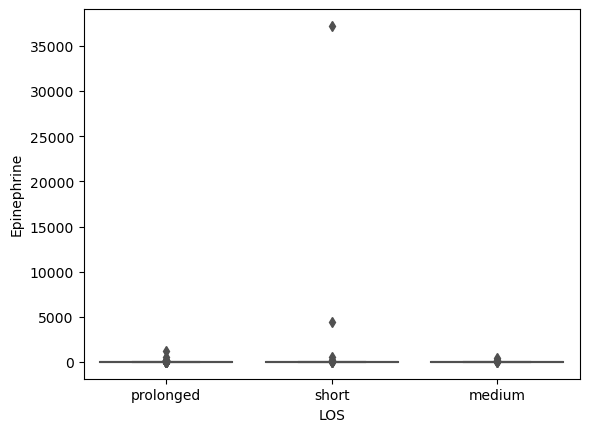

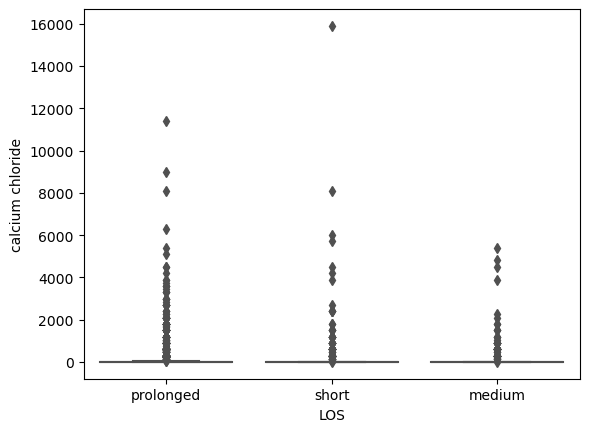

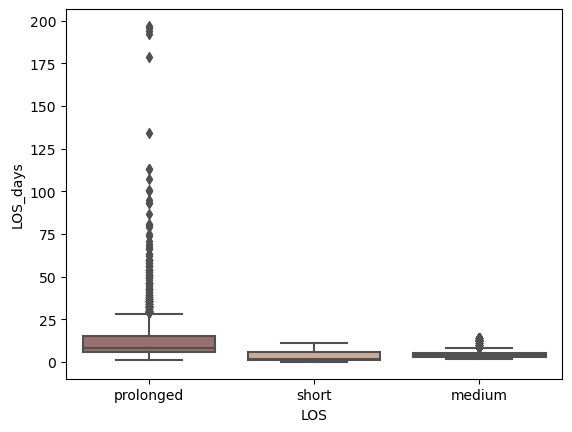

In [84]:
#visualizing distribution of our numerical columns against our target LOS with boxplot

for col in numerical.columns:
    sns.boxplot(data=df2, x="LOS", y=col,  palette = 'pink')
    plt.show()

We can see the presence of outliers in some columns, we will check them later.

### 4.1 Numerical Features Correlation

Let's explore the correlation between independent features with a heatmap and check if there is any **multicollinearity** (highly correlated features)


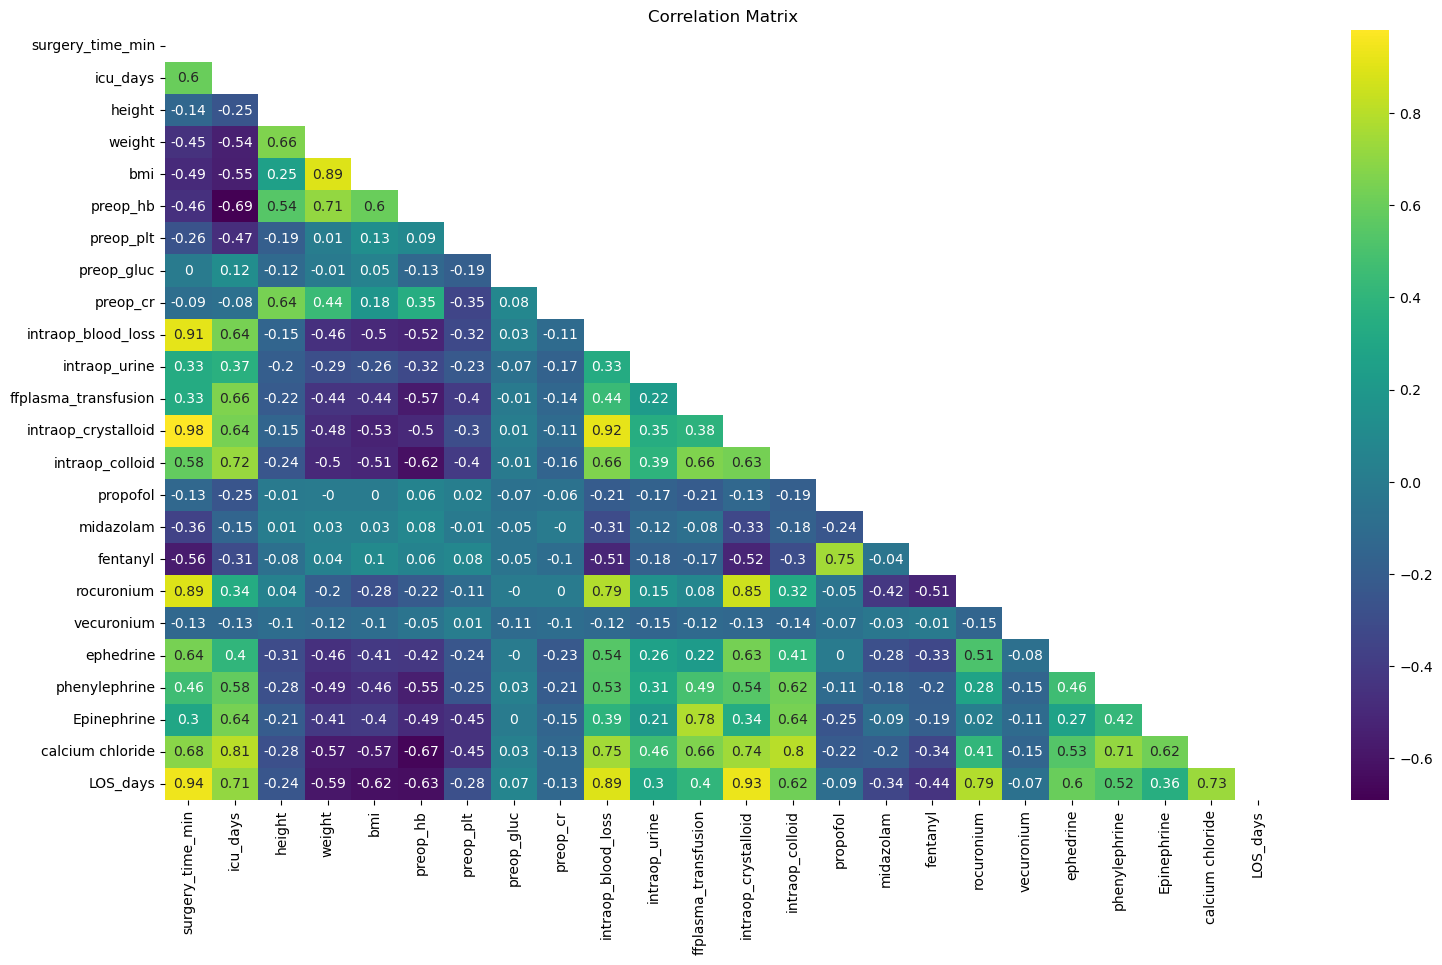

In [86]:
correlations_matrix = df2.corr(method='spearman')  #spearman's correlation matrix (Because the relation of the continous numerical variables are not strictly linear and I have ordinal variables as well. 
correlations_matrix=round(correlations_matrix.corr(),2)

mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, map = plt.subplots(figsize=(18, 10))
map = sns.heatmap(correlations_matrix, mask=mask, annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

Features highly correlated with each other are more dependent and have the same affect on our target "LOS".
To avoid redundant information I am going to keep only one feature from each correlated group, the one less correlated with LOS_days which was the column used to create our multiclass target "LOS".

Highly correlated features: 
- BMI with weight: Drop BMI
- intraop_crystalloid with intraop_blood_loss -DROP intraop_blood_loss
- rocuronium with intraop_crystalloid - DROP rocuronium.
- surgery_time_min correlated with intraop_blood_loss, intraop_crystalloid and rocuronium.

Drop BMI, intraop_blood_loss and rocuronium.

In [87]:
drop_columns=(['bmi', 'intraop_blood_loss', 'rocuronium'])
df_cleaned = df_cleaned.drop(columns=drop_columns) 

In [91]:
# Saving data cleaned to a new csv

df_cleaned.to_csv("data_cleaned.csv", index=False)

### Next: Script "02_Preprocessing2_Modeling"